In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib as mpl
import math
from skimage import color, data, restoration
from PIL import Image
from numpy import asarray
from scipy import signal
from scipy.optimize import curve_fit
#from pynverse import inversefunc

In [78]:
images = []
imagess = []
image = []
name="1. RAW2/"
name1="2. FF/"
namess = ["RAW_sangreM8.txt", "RAW_sangreM6.txt", "RAW_sangreM4.txt", "RAW_sangreM2.txt", "RAW_sangreP2.txt", 
"RAW_sangreP4.txt", "RAW_sangreP6.txt", "RAW_sangreP8.txt"]
names = ["FF_sangreM8.txt", "FF_sangreM6.txt", "FF_sangreM4.txt", "FF_sangre0.txt", "FF_sangreP2.txt", 
"FF_sangreP4.txt", "FF_sangreP6.txt", "FF_sangreP8.txt"]

In [79]:
def Raws(name1,name2):
    RAW = np.rot90(np.genfromtxt(name1 + name2),1)
    s = np.zeros((len(RAW),len(RAW[0])))
    for i in range(len(RAW)):
        for j in range(len(RAW)):
            if np.isnan(RAW[i,j]):
                RAW[i,j] = 0.0
    for i in range(len(RAW)):
        for j in range(len(RAW[0])):
            if RAW[i,j] == 0.0:
                a = i
                b = j
                c = 0
                suma = 0
                borde = 0
                for k in range(a-1, a+2):
                    for n in range(b-1, b+2):   
                        try:
                            suma += RAW[k,n]
                            if RAW[k,n] == 0.0:
                                c = c + 1
                        except:
                            borde = 1

                if borde == 0:
                    RAW[i,j] = suma/(9-c)
                else:
                    RAW[i,j] = suma/(6-c)
    return RAW

In [80]:
def profile_pixel(images,i,j):
    points = []
    for image in images:
        points.append(image[i,j])
    return points

In [81]:
def func(x, A, b, m, r):
    k = A*np.sin(b*x+m)+r
    return k

In [82]:
def Guess(name):
    xvall=np.arange(len(names))
    ff=np.fft.fftfreq(len(xvall), (xvall[1]-xvall[0]))
    Fyy = abs(np.fft.fft(name))
    guess_freq=2*np.pi*abs(ff[np.argmax(Fyy[1:])+1])
    I=[name.std()*2**0.5, guess_freq, 0, name.mean()]
    return I

In [83]:
def fit1(name):
    xvall=np.arange(len(names))
    popt,pcov1 = curve_fit(func, xvall, name,  Guess(name), maxfev=6000)
    return popt

In [84]:
for i in range(len(names)):
    RawCC=Raws(name1,names[i])/Raws(name,namess[i])
    RawC=(RawCC-np.min(RawCC))/(np.max(RawCC)+np.min(RawCC))
    image.append(RawC)

In [85]:
for i in range(len(names)):
    img = (Raws(name,namess[i])-np.min(Raws(name,namess[i])))/(np.max(Raws(name,namess[i]))-np.min(Raws(name,namess[i])))
    images.append(img)
images = np.array(images)

In [86]:
CI_nM = []
xdata = np.arange(len(names))
for i in range(256):
    for j in range(256):
        CI_nM.append(profile_pixel(images,i,j))

CI_nM = np.array(CI_nM)
CI_nM = CI_nM.reshape((256,256,len(names)))

In [87]:
Fits_nM = []
for i in range(256):
    for j in range(256):
        Fits_nM.append(fit1(CI_nM[i,j]))

Fits_nM = np.array(Fits_nM)
Fits_nM = Fits_nM.reshape((256,256,4))

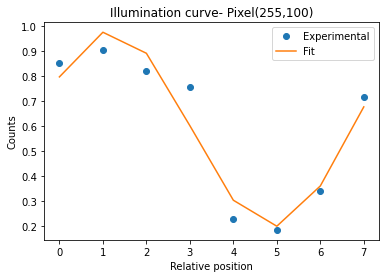

In [88]:
plt.plot(CI_nM[0,0], "o",label="Experimental" )
plt.plot(xdata, func(xdata, *Fits_nM[0,0,:]),label="Fit")
plt.title("Illumination curve- Pixel(255,100)")
plt.ylabel("Counts")
plt.xlabel("Relative position")
plt.legend()

In [89]:
x1=7
x2=3
I_1=image[x1]
I_2=image[x2]
P_i=(I_1-I_2)/(I_1+I_2)
Phi_k=np.zeros((256,256))
for i in range(len(Phi_k)):
    for j in range(len(Phi_k)):
        I=func(x1, *Fits_nM[i,j,:])+func(x2, *Fits_nM[i,j,:])
        I_l=2*Fits_nM[i,j,0]*np.sin((Fits_nM[i,j,1]/2)*(x1-x2))
        P=(P_i[i,j]*I)/(I_l)
        O=np.arccos(P)-(Fits_nM[i,j,1]/2)*(x1-x2)-Fits_nM[i,j,2]
        Phi_k[i,j]=O

/var/folders/gt/fh8j82dx4cj4lsdqnyn6l2fh0000gn/T/ipykernel_21039/315803032.py:12: RuntimeWarning: invalid value encountered in arccos
  O=np.arccos(P)-(Fits_nM[i,j,1]/2)*(x1-x2)-Fits_nM[i,j,2]


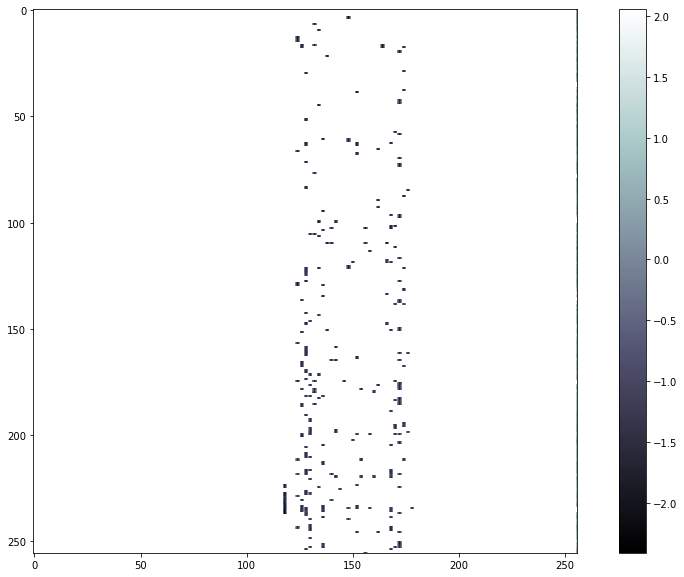

In [90]:
plt.figure(figsize=(15,10))
plt.imshow(Phi_k, cmap="bone")
plt.colorbar()

In [75]:
s = np.zeros((len(Phi_k),len(Phi_k[0])))
for i in range(len(Phi_k)):
    for j in range(len(Phi_k)):
         if np.isnan(Phi_k[i,j]):
            Phi_k[i,j] = 0.0
for i in range(len(Phi_k)):
    for j in range(len(Phi_k[0])):
        if Phi_k[i,j] == 0.0:
            a = i
            b = j
            c = 0
            suma = 0
            borde = 0
            for k in range(a-1, a+2):
                for n in range(b-1, b+2):   
                    try:
                        suma += Phi_k[k,n]
                        if Phi_k[k,n] == 0.0:
                            c = c + 1
                    except:
                        borde = 1

            if borde == 0:
                Phi_k[i,j] = suma/(9-c)
            else:
                Phi_k[i,j] = suma/(6-c)

In [76]:
I_a=np.zeros((256,256))
for i in range(len(I_a)):
    for j in range(len(I_a)):
        I=func(x1, *Fits_nM[i,j,:])+func(x2, *Fits_nM[i,j,:])
        P=(I_1[i,j]+I_2[i,j])/(I)
        I_a[i,j]=P

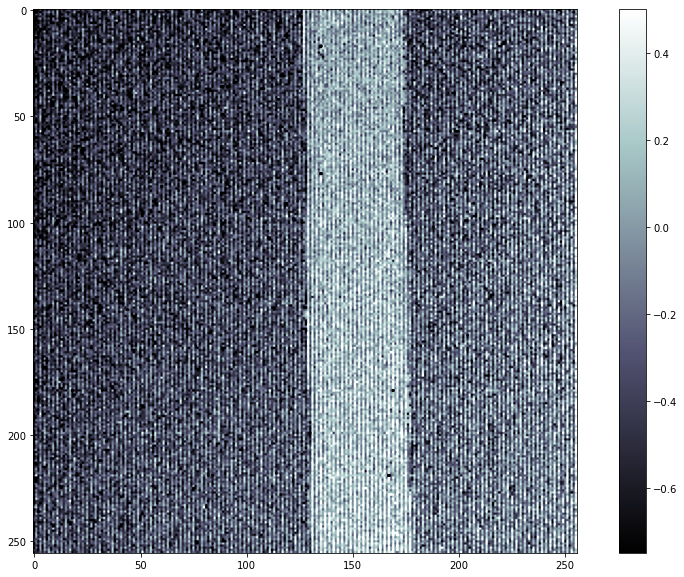

In [77]:
plt.figure(figsize=(15,10))
plt.imshow(Phi_k, cmap="bone",vmin=-0.75, vmax=0.5)
plt.colorbar()

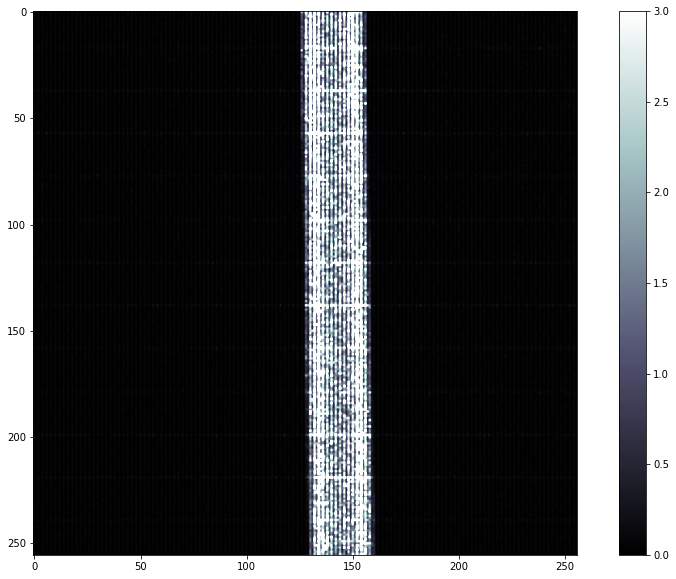

In [53]:
plt.figure(figsize=(15,10))
plt.imshow(I_a, cmap="bone",vmin=0, vmax=3)
plt.colorbar()

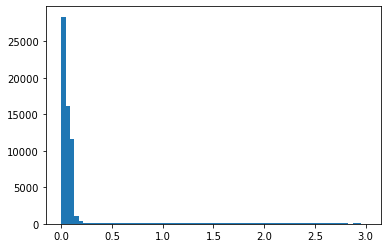

In [54]:
h=plt.hist(np.ravel(I_a), bins=70, range=(0,3))

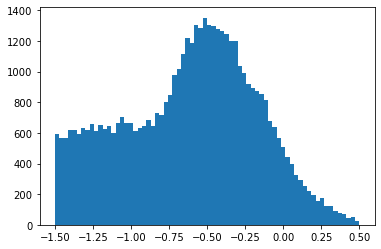

In [55]:
h_1=plt.hist(np.ravel(Phi_k), bins=70, range=(-1.5,0.5))

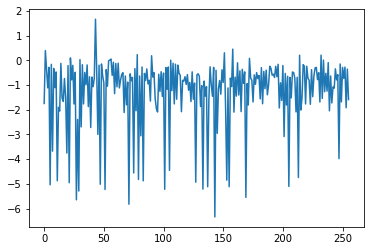

In [56]:
plt.plot(Phi_k[100,:])

In [57]:
frr = np.fft.fft2(I)
frr = np.fft.fftshift(frr)
frr_abs = np.abs(frr)
plt.figure(figsize=(15,10))
plt.imshow(-np.log(frr_abs), cmap="bone")
plt.colorbar()

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
array_dist=np.zeros((len(Phi_k),len(Phi_k)))

array_dist[70:190:, :] = 1

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(array_dist, cmap="bone")
plt.colorbar()

In [ ]:
g=array_dist*frr
frr_abs1=np.abs(g)
plt.figure(figsize=(15,10))
plt.imshow(frr_abs1, cmap="bone")
plt.colorbar()

In [ ]:
f_ishift = np.fft.ifftshift(g)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.figure(figsize=(10,10))
plt.imshow(img_back, cmap="bone",vmin=-1, vmax=0.5)
plt.colorbar()